In [1]:
import rasterio as rio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error
import seaborn as sns
from functools import reduce
from scipy.stats import gaussian_kde
from collections import defaultdict

In [2]:
def scaled(x):
    min_val, max_val = np.percentile(x, (2, 98))

    # Scale the pixel values to the range of 0-255
    return np.interp(x, (min_val, max_val), (0, 255)).astype(np.uint8)

def sigmoid(x):
    return 255 / (1 + np.exp(-4 * (scaled(x) / 255 - 0.5)))

def get_detect_cloud_bands(img):
    bands = [sigmoid(img.read(b)) for b in img.indexes]
    bands = np.stack(bands)
    return bands.transpose(1,2,0).astype(np.uint)
    

In [3]:
path = Path('../../imgs')
images = {p.name: p  for p in path.iterdir()}
path_imgs = [im for im in images['s2'].iterdir()]
rio_cloudless = [get_detect_cloud_bands(rio.open(path)) for path in path_imgs]
path_imgs = [im for im in images['s2_cloudy'].iterdir()]
rio_cloudies = [get_detect_cloud_bands(rio.open(path)) for path in path_imgs]

In [13]:
def kde_gen(scenes, band):
    for scene in scenes:
        data = scene[:, :, band].ravel()
        kde = gaussian_kde(data)
        x_vals = np.linspace(0, 255, 80)
        y_vals = kde(x_vals)
        yield y_vals
    
def kde_mean_scene(scenes):
    res = defaultdict(list)
    for band in range(13):
        res[f"band_{band + 1}"].extend(np.array([val for val in kde_gen(scenes, band)]))
    return res
            
res = kde_mean_scene(rio_cloudies)

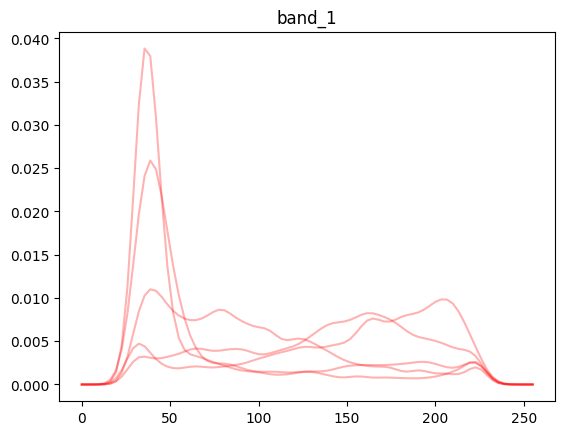

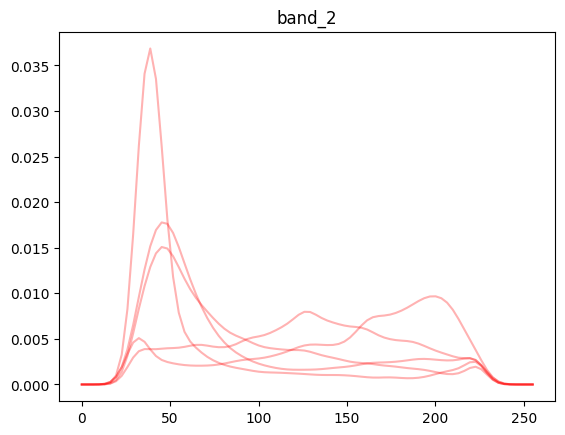

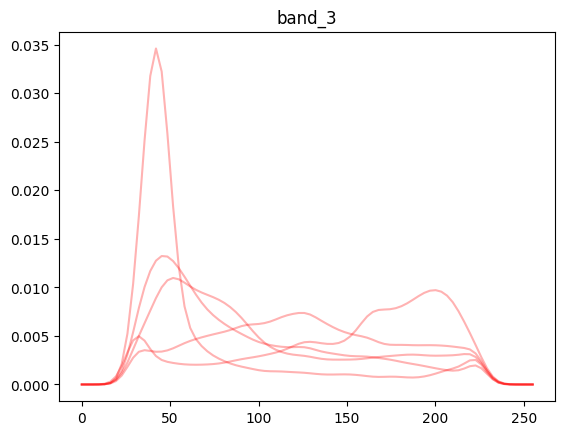

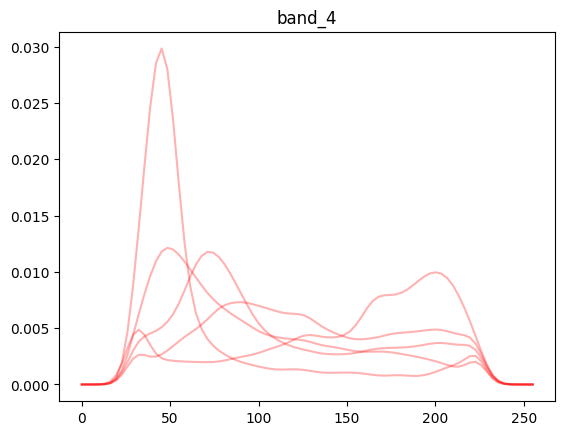

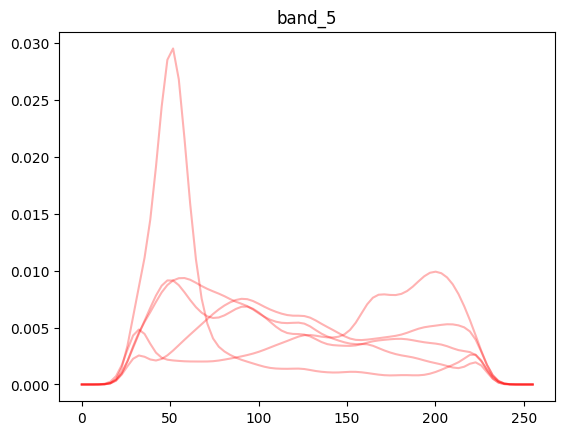

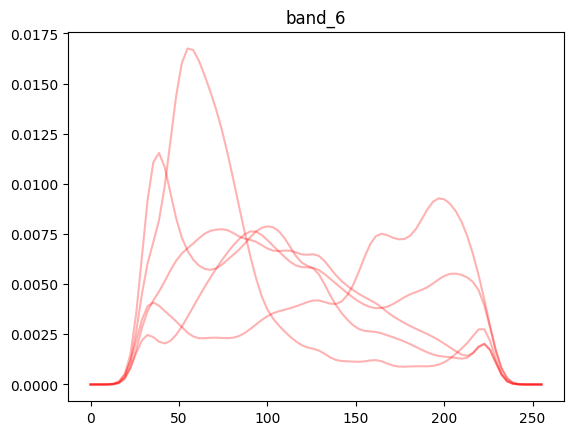

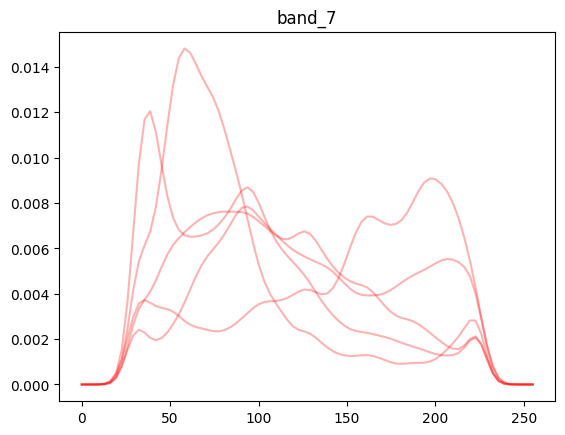

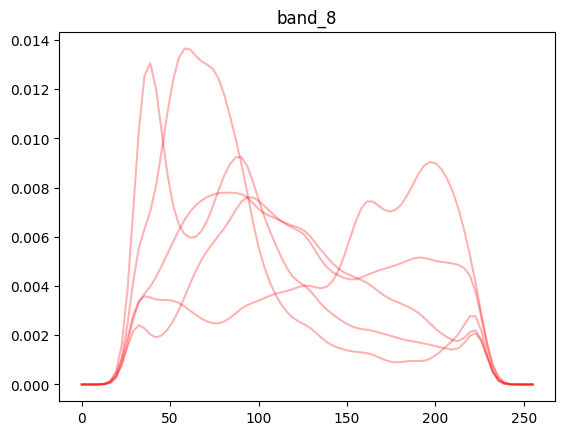

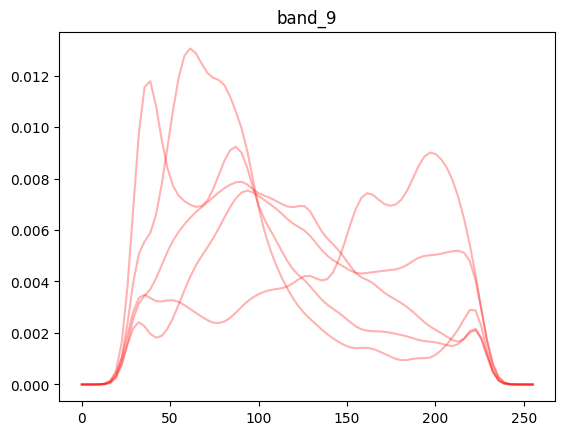

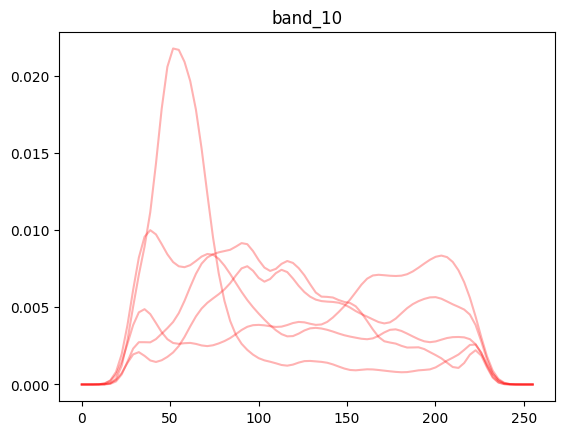

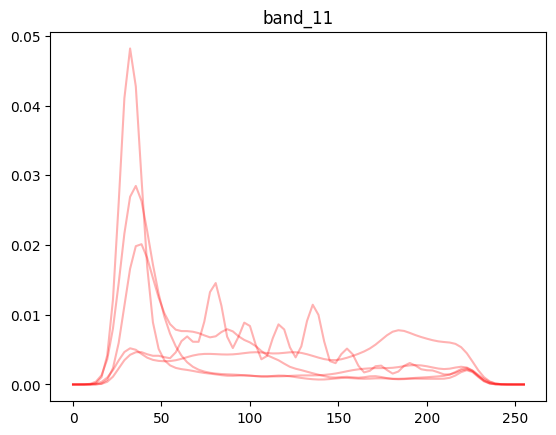

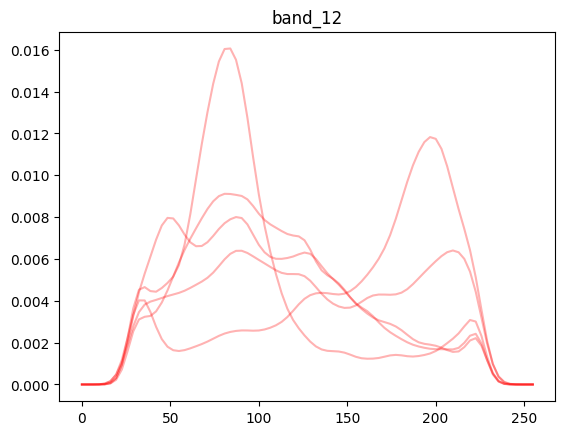

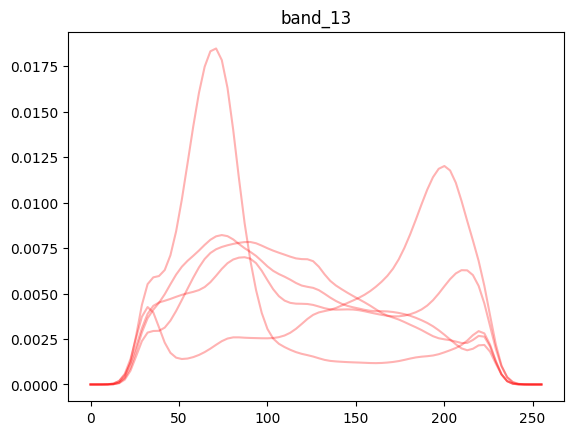

In [15]:
for band, y in res.items():
    plt.title(band)
    for line in y:
        plt.plot(np.linspace(0, 255, 80), line, alpha=0.3, c='r')
    plt.show()